# Base

extract pdf with pdfminer

In [1]:
pip install pdfminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 52.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.7 MB/s eta 0:00:00
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140073 sha256=820900128fbdf18f7a5bfe791678095fc52fd25c7bf605d030c06c69f11acf2e
  Stored in directory: /root/.cache/pip/wheels/56/24/93/05316c6df89ff210a9a705060277e3acbfd2d1bd3a5853ee19
Successfully built pdfminer


In [2]:
!pip install pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.9 MB/s eta 0:00:00


In [3]:
from google.colab import files
import os
import shutil

uploaded = files.upload()

# Buat folder jika belum ada
os.makedirs("data/pdf", exist_ok=True)

# Pindahkan file ke folder data/pdf
for filename in uploaded.keys():
    shutil.move(filename, f"data/pdf/{filename}")

Saving putusan_167_pid.sus_2024_pn_mlg_20250620130143.pdf to putusan_167_pid.sus_2024_pn_mlg_20250620130143.pdf
Saving putusan_441_pid.sus_2024_pn_mlg_20250620130101.pdf to putusan_441_pid.sus_2024_pn_mlg_20250620130101.pdf
Saving putusan_438_pid.sus_2024_pn_mlg_20250620130029.pdf to putusan_438_pid.sus_2024_pn_mlg_20250620130029.pdf
Saving putusan_392_pid.sus_2024_pn_mlg_20250620125752.pdf to putusan_392_pid.sus_2024_pn_mlg_20250620125752.pdf
Saving putusan_421_pid.sus_2024_pn_mlg_20250620125712.pdf to putusan_421_pid.sus_2024_pn_mlg_20250620125712.pdf
Saving putusan_46_pid.sus_2025_pn_mlg_20250620125612.pdf to putusan_46_pid.sus_2025_pn_mlg_20250620125612.pdf
Saving putusan_12_pid.sus_2025_pn_mlg_20250620125454.pdf to putusan_12_pid.sus_2025_pn_mlg_20250620125454.pdf
Saving putusan_57_pid.sus_2025_pn_mlg_20250620125315.pdf to putusan_57_pid.sus_2025_pn_mlg_20250620125315.pdf
Saving putusan_53_pid.sus_2025_pn_mlg_20250620125128.pdf to putusan_53_pid.sus_2025_pn_mlg_20250620125128.pdf


Convert & Extraction Text

In [4]:
from pdfminer.high_level import extract_text
import os
import re

# Lokasi folder
input_folder = 'data/pdf/'
output_folder = 'data/convert/'  # jangan pakai '/' di depan kalau bukan root
os.makedirs(output_folder, exist_ok=True)

# Ambil semua file PDF
pdf_files = [f for f in os.listdir(input_folder) if f.endswith(".pdf")]

for idx, filename in enumerate(pdf_files, 1):
    pdf_path = os.path.join(input_folder, filename)
    text = extract_text(pdf_path)

    # 1. Bersihkan dan gabungkan setiap baris dengan spasi
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    combined = ' '.join(lines)

    # 2. Sisipkan spasi di antara huruf kecil dan huruf kapital yang menempel (contoh: "JiminTempat")
    combined = re.sub(r'([a-z])([A-Z])', r'\1 \2', combined)

    # 3. Hilangkan spasi ganda akibat proses join
    cleaned_text = re.sub(r'\s{2,}', ' ', combined)

    # Simpan hasil ekstraksi ke file .txt dengan nama putusan001.txt, dst.
    output_path = os.path.join(output_folder, f"putusan{idx:03}.txt")
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(cleaned_text)

Preprocessing

In [5]:
def clean_header_footer(text):
    lines = text.splitlines()  # Pisah jadi list per baris
    cleaned_lines = []

    for line in lines:
        # Hilangkan kata-kata target dari tiap baris
        line = line.replace("Direktori Putusan Mahkamah Agung Republik Indonesia", "")
        line = line.replace("Mahkamah Agung Republik Indonesia", "")
        line = line.replace("putusan.mahkamahagung.go.id", "")

        # Hapus baris jika kosong setelah dibersihkan
        if line.strip():  # cek jika masih ada isi
            cleaned_lines.append(line.strip())

    return '\n'.join(cleaned_lines)

In [6]:

import re

def clean_footer(text):
    cleaned_text = re.sub(
        r"Disclaimer[\s\S]*?(Email\s*:\s*.+?[\n\r]+)?Telp\s*:\s*\d{3}[-\s]?\d{3,4}(?:[-\s]?\d{3,4})?\s*",
        "",
        text,
        flags=re.IGNORECASE
    )
    return cleaned_text.strip()

In [7]:
import re
def normalize_text(text):
    text = text.lower()                             # lowercase semua
    text = re.sub(r'\b(?:[a-zA-Z]\s+){2,}[a-zA-Z]\b', lambda m: m.group(0).replace(' ', ''), text)

    return text

In [8]:
import re

def clean_putusan_text(text):
    cleaned_lines = []

    # Pola watermark halaman
    pattern = re.compile(
        r'^\s*(Hal\.?|Halaman)\s+\d+\s+(dari|/)\s+\d+\s+Putusan\s+Nomor\s+[0-9./\-]+/[a-zA-Z]+/[0-9]{4}/PN\s+\w+\s*$',
        flags=re.IGNORECASE
    )

    for line in text.splitlines():
        # Hanya hapus baris yang benar-benar cocok watermark
        if not pattern.match(line.strip()):
            cleaned_lines.append(line)

    return "\n".join(cleaned_lines).strip()


In [9]:
def clean_text_pipeline(text):
    text = clean_header_footer(text)
    text = clean_footer(text)
    text = clean_putusan_text(text)

    # Hapus semua "Halaman X"
    text = re.sub(r"(?i)\bhalaman\s*\d+(\s*dari\s*\d+)?\b", "", text)

    text = normalize_text(text)
    return text

In [10]:
import os

input_folder = "data/convert"
output_folder = "data/raw"

# Pastikan folder output ada
os.makedirs(output_folder, exist_ok=True)

# Ambil semua file .txt dari folder input dan urutkan
txt_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".txt")])

for i, filename in enumerate(txt_files, start=1):
    input_path = os.path.join(input_folder, filename)

    with open(input_path, "r", encoding="utf-8") as f:
        text = f.read()

    # Bersihkan teks dengan pipeline
    cleaned_text = clean_text_pipeline(text)

    # Format nama file output: case_001.txt, case_002.txt, ...
    output_filename = f"case_{i:03}.txt"
    output_path = os.path.join(output_folder, output_filename)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(cleaned_text)


# representation

In [11]:
import re

def nomor_perkara(text):
    # Tangkap pola nomor perkara umum seperti "167/Pid.Sus/2024/PN Mlg"
    match = re.search(
        r'\d+\s*/\s*Pid\.Sus\s*/\s*\d{4}\s*/\s*PN\s+\w+',
        text,
        flags=re.IGNORECASE
    )
    if match:
        return match.group()
    return None


In [12]:
import re

def amar_putusan(text):
    # Normalisasi format penomoran
    text = re.sub(r"(\d+)\.(\S)", r"\1. \2", text)
    text = re.sub(r";\s*(\d+)\.", r"; \1.", text)

    # Deteksi 'mengadili'
    pattern_mengadili = re.compile(r"(m\s*e\s*n\s*g\s*a\s*d\s*i\s*l\s*i\s*:?)|\bmengadili\s*:?", flags=re.IGNORECASE)
    matches = list(pattern_mengadili.finditer(text))
    if not matches:
        return "Tidak ditemukan kata 'mengadili'"

    # Ambil teks setelah 'mengadili'
    last_match = matches[-1]
    amar_text = text[last_match.end():].strip()

    # Gabungkan baris terpisah
    amar_text = re.sub(r'\n+', ' ', amar_text)

    # Ambil poin-poin bernomor
    poin_matches = re.findall(r"\d+\.\s+(.*?)(?=(?:\d+\.\s)|$)", amar_text, flags=re.DOTALL)
    cleaned = []

    if poin_matches:
        for poin in poin_matches[:5]:
            sentence = re.sub(r'\s+', ' ', poin.strip())

            # Deteksi dan ganti frasa denda yang tidak lengkap dengan terbilang
            if re.search(r"denda\s+sejumlah\s+Rp[^\w]*", sentence, flags=re.IGNORECASE):
                # Cari frasa terbilang di kalimat berikutnya (asumsinya langsung lanjut)
                terbilang_match = re.search(r"\((satu .*?rupiah)\)", text, flags=re.IGNORECASE)
                if terbilang_match:
                    terbilang = terbilang_match.group(1).strip()
                    sentence = re.sub(r"denda\s+sejumlah\s+Rp[^\s]*", f"denda sejumlah {terbilang}", sentence, flags=re.IGNORECASE)
                else:
                    # fallback jika tidak ditemukan terbilang
                    sentence = re.sub(r"denda\s+sejumlah\s+Rp[^\s]*", "denda sejumlah tidak diketahui", sentence, flags=re.IGNORECASE)

            if not sentence.endswith('.'):
                sentence += '.'
            cleaned.append(sentence)
    else:
        # fallback kalimat biasa
        kalimat_matches = re.split(r'(?<=[.;])\s+', amar_text)
        for k in kalimat_matches[:2]:
            sentence = re.sub(r'\s+', ' ', k.strip())
            if not sentence.endswith('.'):
                sentence += '.'
            cleaned.append(sentence)

    # Ambil dua kalimat paling relevan
    pidana_denda = [s for s in cleaned if 'pidana' in s.lower() or 'denda' in s.lower()]
    result = pidana_denda[:2] if len(pidana_denda) >= 2 else cleaned[:2]

    return ' '.join(result)


In [13]:
import re

def extract_pekerjaan(text):
    # 1. Bagi berdasarkan terdakwa: pakai romawi diikuti angka dan titik (misalnya: i.1., ii.1., dst)
    # Asumsikan bagian terdakwa diakhiri sebelum "mengadili" atau "menimbang" atau teks utama dimulai
    parts = re.split(r"(?=\b(?:i{1,3}|iv|v|vi|vii|viii|ix|x)[.]\s*1[.])", text, flags=re.IGNORECASE)

    pekerjaan_list = []

    for part in parts:
        # 2. Cari 'pekerjaan' di setiap bagian
        match = re.search(
            r"(?i)pekerjaan\s*:?\s*(.+?)(?=\s*(?:agama|pendidikan|terdakwa|status|[0-9]{1,2}[.)])\b|[;\n\.]|$)",
            part
        )
        if match:
            pekerjaan = re.sub(r'\s+', ' ', re.sub(r',+', '', match.group(1))).strip()
            pekerjaan_list.append(pekerjaan)

    return pekerjaan_list

In [14]:
import re

def extract_penuntut_umum(text):
    # Tangani jika HANYA ada Penuntut Umum TANPA nama
    pattern_tanpa_nama = r"(?:dengan|serta)[\s]*dihadiri[\s]*oleh[\s]*(?:Jaksa[\s]*Penuntut[\s]*Umum|Penuntut[\s]*Umum|JaksaPenuntutUmum|PenuntutUmum)(?![\w])"
    if re.search(pattern_tanpa_nama, text, re.IGNORECASE | re.DOTALL):
        return "tidak disebutkan"

    # Tangani jika nama disebutkan sebelum frasa penuntut umum
    pattern_nama = r"(?:dengan|serta)[\s]*dihadiri[\s]*oleh[\s]*([\w\s.,()-]+?)\s*(?:selaku|sebagai)?\s*(?:Jaksa[\s]*Penuntut[\s]*Umum|Penuntut[\s]*Umum|JaksaPenuntutUmum|PenuntutUmum)"
    match = re.search(pattern_nama, text, re.IGNORECASE | re.DOTALL)
    if match:
        return match.group(1).strip()

    return "tidak ada informasi"

In [15]:
import re

def nama_terdakwa(text):
    pattern = r"(?i)(?:\d\.\s*)?(?:nama lengkap|nama)\s*:?\s*([\s\S]{3,100}?)(?=\s*(?:\d?[.)]?\s*)?tempat\s+lahir)"
    return [m.strip() for m in re.findall(pattern, text)]

In [16]:
import re

def extract_ringkasan_barang_bukti(text):
    # Ambil bagian setelah "mengadili"
    mengadili_matches = list(re.finditer(r"mengadili", text, flags=re.IGNORECASE))
    if not mengadili_matches:
        return "tidak ditemukan bagian mengadili"

    last_mengadili = mengadili_matches[-1].end()
    sisa_text = text[last_mengadili:]

    # Temukan frasa "barang bukti berupa", fleksibel terhadap spasi & newline
    match_bb = re.search(
        r"(?:menetapkan|menyatakan)?(?:\s+|\n+)*(?:agar\s+)?barang(?:\s+|\n+)bukti(?:\s+|\n+)?(?:masing[-\s]masing\s+)?berupa(?:\s+|\n+)*:?",
        sisa_text,
        flags=re.IGNORECASE
    )

    if not match_bb:
        return "tidak ditemukan bagian barang bukti berupa"

    start_idx = match_bb.end()
    after_bb = sisa_text[start_idx:]

    # Potong sampai sebelum bagian penutup
    stop_match = re.search(r"(membebankan|putusan|demikianlah|pasal|hakim)", after_bb, flags=re.IGNORECASE)
    if stop_match:
        after_bb = after_bb[:stop_match.start()]

    # Ambil poin-poin barang bukti
    poin_match = re.findall(r"[-•\d]+[.)]?\s*(.+?)(?=(?:\n[-•\d]+[.)]?\s)|\Z)", after_bb.strip(), flags=re.DOTALL)

    if not poin_match:
        return "tidak ditemukan poin barang bukti"

    empat_barang = [re.sub(r"\s+", " ", item.strip()) for item in poin_match[:4]]
    return "Barang bukti berupa: " + "; ".join(f"- {item}" for item in empat_barang) + "."


In [17]:
import re

def extract_metadata(text):
    data = {}

    # Nomor perkara
    data['nomor_perkara'] = nomor_perkara(text)

    # m = re.findall(r"nama lengkap\s*:?\s*([a-zA-Z.,\-\s]+)", text, flags=re.IGNORECASE)
    data['nama_terdakwa'] = nama_terdakwa(text)

    # Pekerjaan
    data['pekerjaan'] = extract_pekerjaan(text)

    # perkara
    m = re.search(r"\b(tindak pidana.*?)\b(narkotika|psikotropika|prekursor narkotika)\b", text, flags=re.IGNORECASE)
    data['tindak pidana'] = m.group(2).capitalize() if m else "tidak ada informasi"

    # Pasal
    m = re.search(r"Pasal\s+[^\n]*?Tahun\s+\d{4}", text, flags=re.IGNORECASE)
    data['pasal'] = m.group(0).strip() if m else ""

    # penuntut umum / penggugat
    data['penuntut_umum'] = extract_penuntut_umum(text)

    # Tanggal (optional)
    m = re.search(r"(diputuskan|putusan)[^\n]*tanggal\s+(\d{1,2}\s+[A-Za-z]+\s+\d{4})", text, flags=re.IGNORECASE)
    data['tanggal_putusan'] = m.group(2).strip() if m else ""

    # penuntut umum / penggugat
    data['amar_putusan'] = amar_putusan(text)

    # penuntut umum / penggugat
    data['barang_bukti'] = extract_ringkasan_barang_bukti(text)
    return data

In [18]:
import pandas as pd
import os

# Misal nama file yang mau diuji
filename = "data/raw/case_013.txt"

# Baca file
with open(os.path.join(filename), 'r', encoding='utf-8') as f:
    text = f.read()
    metadata = extract_metadata(text)
    metadata['case_id'] = "case_001"
    metadata['text_full'] = text

# Simpan ke DataFrame (1 baris saja)
df = pd.DataFrame([metadata])
df

,nomor_perkara,nama_terdakwa,pekerjaan,tindak pidana,pasal,penuntut_umum,tanggal_putusan,amar_putusan,barang_bukti,case_id,text_full
0,11/pid.sus/2025/pn mlg,[tri bambang aditiyo bin bambang isnian-to;],[karyawan swasta],Narkotika,pasal 25) sejak tanggal 30 desember 2024 sampa...,"dewangga kurniawan, s.h.,",17 maret 2025,menyatakan terdakwa tri bambang aditiyo bin ba...,Barang bukti berupa: - (satu) kotak plastik wa...,case_001,(ext.318) putusa nnomor 11/pid.sus/2025/pn ml...


In [19]:
import pandas as pd
import os

# Folder input
input_dir = "data/raw"

# List untuk menampung metadata semua file
all_data = []

# Loop semua file .txt
for filename in os.listdir(input_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_dir, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            metadata = extract_metadata(text)
            metadata['case_id'] = os.path.splitext(filename)[0]
            metadata['text_full'] = text
            all_data.append(metadata)

# Buat DataFrame dari semua metadata
df = pd.DataFrame(all_data)
# Hitung length (jumlah kata)
df["length_text_full"] = df["text_full"].astype(str).apply(lambda x: len(x.split()))

# Tampilkan DataFrame
print(df)

              nomor_perkara  \
0    30/pid.sus/2025/pn mlg   
1    29/pid.sus/2025/pn mlg   
2    74/pid.sus/2025/pn mlg   
3   441/pid.sus/2024/pn mlg   
4   102/pid.sus/2025/pn mlg   
5    82/pid.sus/2025/pn mlg   
6   449/pid.sus/2024/pn mlg   
7   392/pid.sus/2024/pn mlg   
8    90/pid.sus/2025/pn mlg   
9   167/pid.sus/2024/pn mlg   
10   11/pid.sus/2025/pn mlg   
11   46/pid.sus/2025/pn mlg   
12  107/pid.sus/2025/pn mlg   
13   14/pid.sus/2025/pn mlg   
14   31/pid.sus/2025/pn mlg   
15   61/pid.sus/2025/pn mlg   
16  438/pid.sus/2024/pn mlg   
17   38/pid.sus/2025/pn mlg   
18  112/pid.sus/2025/pn mlg   
19   48/pid.sus/2025/pn mlg   
20   15/pid.sus/2025/pn mlg   
21   57/pid.sus/2025/pn mlg   
22   12/pid.sus/2025/pn mlg   
23   64/pid.sus/2025/pn mlg   
24  421/pid.sus/2024/pn mlg   
25   72/pid.sus/2025/pn mlg   
26   75/pid.sus/2025/pn mlg   
27  113/pid.sus/2025/pn mlg   
28   53/pid.sus/2025/pn mlg   
29   91/pid.sus/2025/pn mlg   

                                      

In [20]:
import os

# Buat folder jika belum ada
os.makedirs("data/processed", exist_ok=True)

# Simpan file
df.to_json("data/processed/cases.json", orient='records', indent=2, force_ascii=False)


# retrieval

In [21]:
df_loaded = pd.read_json("data/processed/cases.json")
df_loaded.head(5)

,nomor_perkara,nama_terdakwa,pekerjaan,tindak pidana,pasal,penuntut_umum,tanggal_putusan,amar_putusan,barang_bukti,case_id,text_full,length_text_full
0,30/pid.sus/2025/pn mlg,[feryan bagas aditya als momon bin bambang suw...,[petani/pekebun],Narkotika,pasal 112 ayat (2) jo. pasal 132ayat (1) undan...,"dita rahmawati, s.h.,",17 maret 2025,menyatakan terdakwa feryan bagas aditya als mo...,Barang bukti berupa: - (satu) pocket narkotika...,case_022,(ext.318) putusa nnomor 30/pid.sus/2025/pn ml...,5629
1,29/pid.sus/2025/pn mlg,[ahmad rudianto als picis bin siswanto],[karyawan swasta],Narkotika,pasal 25)sejak tanggal 30 desember 2024 sampai...,"gusti ayu made dwi kartika, sh,",17 maret 2025,menyatakan terdakwa ahmad rudianto als picis b...,tidak ditemukan poin barang bukti,case_005,(ext.318) putusa nnomor 29/pid.sus/2025/pn.ml...,8872
2,74/pid.sus/2025/pn mlg,[frassetyo nuriman bin budiman;],[karyawan swasta],Narkotika,pasal 114 ayat (2) undang-undang republik indo...,"muh.fahmi mirza barata,s.h.,m.h.,",28 april 2025,menyatakan terdakwa frassetyo nuriman bin budi...,Barang bukti berupa: - (satu) pocket shabu yan...,case_020,(ext.318) putusa nnomor 74/pid.sus/2025/pn ml...,5343
3,441/pid.sus/2024/pn mlg,[muhammad fiqri fauzi bin hariyanto],[pelajar/mahasiswa],Narkotika,pasal 114 ayat (2) uu ri no. 35 tahun 2009,"dewangga kurniawan, s.h.,",17 februari 2025,menyatakan terdakwa muhammad fiqri fauzi bin h...,Barang bukti berupa: - (tiga puluh delapan) bu...,case_030,(ext.318) putusa nnomor 441/pid.sus/2024/pn m...,6741
4,102/pid.sus/2025/pn mlg,[raden herdian murdianto bin raden edi budi sa...,[wiraswasta],Narkotika,pasal 114 ayat (2) uu ri no. 35 tahun2009 tent...,"dewangga kurniawan ,s.h.",21 mei 2025,menyatakan terdakwa raden herdian murdianto bi...,Barang bukti berupa: - (satu) buah bekas bungk...,case_004,(ext.318) putusa nnomor 102/pid.sus/2025/pn m...,9485


In [22]:
!pip install transformers
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [23]:
import os
import json
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [24]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [25]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()

In [26]:
import pandas as pd

# Load file data terstruktur dari tahap Case Representation
df = pd.read_json("data/processed/cases.json")

# Ambil barang_bukti + pasal
case_texts = [
    (str(row["barang_bukti"]) + " " + str(row["pasal"]))
    for _, row in df.iterrows()
]
case_ids = df["case_id"].tolist()

# Hitung embedding semua kasus
case_embeddings = [get_bert_embedding(text) for text in case_texts]

# Simpan embedding dan case_ids
np.save("data/processed/bert_embeddings.npy", case_embeddings)
with open("data/processed/case_ids.json", "w") as f:
    json.dump(case_ids, f)

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [27]:
texts_train, texts_test, ids_train, ids_test = train_test_split(
    case_texts, case_ids, test_size=0.2, random_state=42
)

# Simpan test queries
queries = [{"query_id": i, "text": texts_test[i], "true_case_id": ids_test[i]} for i in range(len(texts_test))]
os.makedirs("data/eval", exist_ok=True)
with open("data/eval/queries.json", "w") as f:
    json.dump(queries, f, indent=2)

In [28]:
def retrieve(query, k=5):
    query_vec = get_bert_embedding(query).reshape(1, -1)

    # Load case base vectors & ids
    case_vecs = np.load("data/processed/bert_embeddings.npy")
    with open("data/processed/case_ids.json") as f:
        case_ids = json.load(f)

    similarities = cosine_similarity(query_vec, case_vecs)[0]
    top_k_indices = similarities.argsort()[-k:][::-1]
    return [case_ids[i] for i in top_k_indices]

In [29]:
# Tes ambil satu query dari queries.json
with open("data/eval/queries.json") as f:
    test_queries = json.load(f)

for q in test_queries[:3]:  # ambil 3 contoh awal
    print(f"\nQuery: {q['text'][:100]}...")
    top_cases = retrieve(q['text'], k=5)
    print(f"Top-5 retrieved: {top_cases}")
    print(f"Ground truth: {q['true_case_id']}")


Query: Barang bukti berupa: - (satu) pocket shabu dibungkus plastik klip bening dengan berat bersih +20,71 ...
Top-5 retrieved: ['case_021', 'case_009', 'case_015', 'case_022', 'case_020']
Ground truth: case_021

Query: Barang bukti berupa: - bungkus plastik klip berisi narkotika jenis sabu dengan beratkotor seluruhnya...
Top-5 retrieved: ['case_017', 'case_001', 'case_006', 'case_019', 'case_025']
Ground truth: case_017

Query: Barang bukti berupa: - (satu) plastik besarberisi ganja dengan berat bersih 935 gram;1 (satu) plast...
Top-5 retrieved: ['case_026', 'case_004', 'case_019', 'case_025', 'case_001']
Ground truth: case_026


# predict

In [30]:
import pandas as pd
import json

df = pd.read_json("data/processed/cases.json")

# Buat mapping case_id → amar_putusan
case_solutions = {
    row["case_id"]: row["amar_putusan"]
    for _, row in df.iterrows()
}

In [31]:
from collections import Counter

def predict_outcome(query: str, k: int = 5) -> str:
    top_k = retrieve(query, k=k)
    solutions = [case_solutions.get(c, "") for c in top_k]

    # Majority vote
    most_common = Counter(solutions).most_common(1)
    predicted_solution = most_common[0][0] if most_common else ""

    return predicted_solution

In [32]:
import pandas as pd
import json
import os

# Load queries
with open("data/eval/queries.json") as f:
    test_queries = json.load(f)

# Jalankan prediksi
results = []
for q in test_queries:
    pred_sol = predict_outcome(q['text'])
    top_k = retrieve(q['text'], k=5)

    results.append({
        "query_id": q['query_id'],
        "predicted_solution": pred_sol,
        "top_5_case_ids": top_k
    })

# Simpan ke CSV
df_preds = pd.DataFrame(results)

# Buat folder 'data/results' jika belum ada
os.makedirs("data/results", exist_ok=True)
df_preds.to_csv("data/results/predictions.csv", index=False)

In [33]:
# perbandingan prediksi dan putusan sebenarnya
for q in test_queries[:5]:
    query = q["text"]
    predicted = predict_outcome(query)
    true_case_id = q["true_case_id"]
    true_solution = case_solutions[true_case_id]

    print(f"\nQuery ID       : {q['query_id']}")
    print(f"Predicted      : {predicted}")
    print(f"Ground Truth   : {true_solution}")



Query ID       : 0
Predicted      : menjatuhkan pidana kepada terdakwa oleh karena itu dengan pidanapenjara selama 10 (sepuluh) tahun dan pidana denda sejumlah tidak diketahui. 000,00 (dua milyar rupiah) dengan ketentuan apabila pidanadenda tersebut tidak dibayar diganti dengan pidana penjara selama 6(enam) bulan;.
Ground Truth   : menjatuhkan pidana kepada terdakwa oleh karena itu dengan pidanapenjara selama 10 (sepuluh) tahun dan pidana denda sejumlah tidak diketahui. 000,00 (dua milyar rupiah) dengan ketentuan apabila pidanadenda tersebut tidak dibayar diganti dengan pidana penjara selama 6(enam) bulan;.

Query ID       : 1
Predicted      : menyatakan terdakwa suwarno dwi prayogobin satuwi terbukti secara sah dan meyakinkan bersalah melakukantindak pidana tanpa hak dan melawan hukum “menjadi perantara dalam jual putusan nomor 61/pid.sus/2025/pn mlg (ext.318) beli narkotika golongan i dalam bentuk bukan tanaman beratnya 5 (lima)gram”;. menjatuhkan pidana kepada terdakwa oleh karena 

# evaluation

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import json

def eval_retrieval(queries, k=5):
    data = []

    for q in queries:
        top_k = retrieve(q["text"], k=k)
        true_id = q["true_case_id"]

        # Binary label: 1 jika benar ada di top-k, 0 jika tidak
        y_true = [1]
        y_pred = [1 if true_id in top_k else 0]

        data.append({
            "query_id": q["query_id"],
            "y_true": y_true[0],
            "y_pred": y_pred[0]
        })

    df = pd.DataFrame(data)

    # Hitung metrik
    acc = accuracy_score(df["y_true"], df["y_pred"])
    prec = precision_score(df["y_true"], df["y_pred"], zero_division=0)
    rec = recall_score(df["y_true"], df["y_pred"], zero_division=0)
    f1 = f1_score(df["y_true"], df["y_pred"], zero_division=0)

    # Simpan ke CSV
    os.makedirs("data/eval", exist_ok=True)
    df.to_csv("data/eval/retrieval_metrics.csv", index=False)

    print("== Retrieval Evaluation ==")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")


In [35]:
def eval_prediction(queries, case_solutions):
    data = []

    for q in queries:
        true_sol = case_solutions[q["true_case_id"]]
        predicted_sol = predict_outcome(q["text"])

        label_true = true_sol.strip().lower()
        label_pred = predicted_sol.strip().lower()

        data.append({
            "query_id": q["query_id"],
            "y_true": label_true,
            "y_pred": label_pred
        })

    df = pd.DataFrame(data)

    # Konversi label jadi kategori unik
    labels = list(set(df["y_true"]) | set(df["y_pred"]))
    acc = accuracy_score(df["y_true"], df["y_pred"])
    prec = precision_score(df["y_true"], df["y_pred"], average='macro', zero_division=0)
    rec = recall_score(df["y_true"], df["y_pred"], average='macro', zero_division=0)
    f1 = f1_score(df["y_true"], df["y_pred"], average='macro', zero_division=0)

    # Simpan ke CSV
    df.to_csv("data/eval/prediction_metrics.csv", index=False)

    print("\n== Prediction Evaluation ==")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [36]:
# Load data
with open("data/eval/queries.json") as f:
    test_queries = json.load(f)

# Panggil evaluasi
eval_retrieval(test_queries, k=5)
eval_prediction(test_queries, case_solutions)

== Retrieval Evaluation ==
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

== Prediction Evaluation ==
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


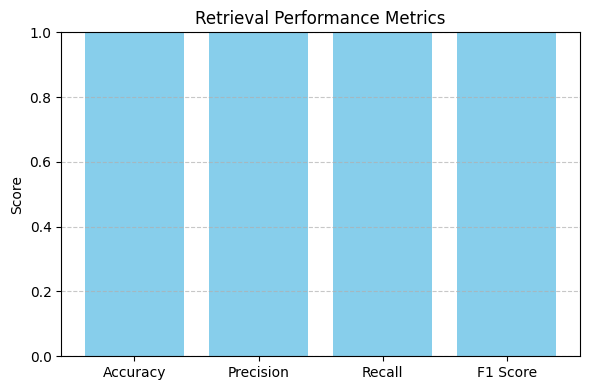

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load hasil retrieval
df_retrieval = pd.read_csv("data/eval/retrieval_metrics.csv")

# Hitung metrik agregat
acc = accuracy_score(df_retrieval["y_true"], df_retrieval["y_pred"])
prec = precision_score(df_retrieval["y_true"], df_retrieval["y_pred"], zero_division=0)
rec = recall_score(df_retrieval["y_true"], df_retrieval["y_pred"], zero_division=0)
f1 = f1_score(df_retrieval["y_true"], df_retrieval["y_pred"], zero_division=0)

# Plot
plt.figure(figsize=(6,4))
plt.bar(["Accuracy", "Precision", "Recall", "F1 Score"], [acc, prec, rec, f1], color="skyblue")
plt.ylim(0, 1)
plt.title("Retrieval Performance Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("data/eval/retrieval_metrics_chart.png")
plt.show()


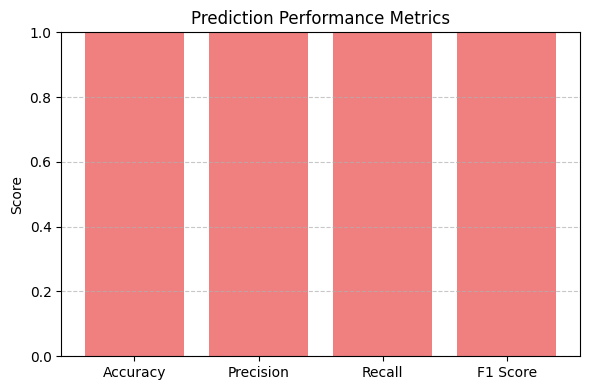

In [38]:
# Load hasil prediction
df_pred = pd.read_csv("data/eval/prediction_metrics.csv")

# Hitung metrik agregat
acc_pred = accuracy_score(df_pred["y_true"], df_pred["y_pred"])
prec_pred = precision_score(df_pred["y_true"], df_pred["y_pred"], average='macro', zero_division=0)
rec_pred = recall_score(df_pred["y_true"], df_pred["y_pred"], average='macro', zero_division=0)
f1_pred = f1_score(df_pred["y_true"], df_pred["y_pred"], average='macro', zero_division=0)

# Plot
plt.figure(figsize=(6,4))
plt.bar(["Accuracy", "Precision", "Recall", "F1 Score"], [acc_pred, prec_pred, rec_pred, f1_pred], color="lightcoral")
plt.ylim(0, 1)
plt.title("Prediction Performance Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("data/eval/prediction_metrics_chart.png")
plt.show()


In [39]:
import pandas as pd

# Baca ulang hasil prediksi
df_pred = pd.read_csv("data/eval/prediction_metrics.csv")

# Tampilkan prediksi yang salah
for i, row in df_pred.iterrows():
    if row["y_true"] != row["y_pred"]:
        print(f"Query ID: {row['query_id']}")
        print(f"True    : {row['y_true']}")
        print(f"Pred    : {row['y_pred']}\n")